In [1]:
# -*- coding:utf -8-*-
import operator
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import word_tokenize, wordpunct_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))

In [2]:
def tokenizator(text):
    text = text.lower()
    text = re.sub("[,;':.?!]", '', text)
    return word_tokenize(text)  

In [3]:
def lemmatizator(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

In [4]:
#а почему бы не взять все сезоны сразу, хмм?
f = pd.read_csv("D:\\All-seasons.csv") 
f = f.dropna() 

In [5]:
#Берем Кайла, Картмана, Стэна и Баттерса. Можно было бы взять Кенни, но он слишком мало говорит (еще меньше, чем Баттерс)
Butters = (f.Character == "Butters")
Cartman = (f.Character == "Cartman")
Kyle = (f.Character == "Kyle")
Stan = (f.Character == "Stan")

B  = f[Butters]
C = f[Cartman]
K = f[Kyle]
S = f[Stan]

In [6]:
#количество фраз
print(len(B), len(C), len(K), len(S))

2602 9774 7099 7680


In [7]:
characters = f[Cartman | Kyle | Stan | Butters]
characters = characters.dropna()
characters = characters.reset_index(drop=True)

In [8]:
#Деление выборки (80 к 20)
X_train, X_test, y_train, y_test = train_test_split(characters['Line'], characters['Character'], test_size=0.2)

In [9]:
countvec = CountVectorizer(tokenizer = word_tokenize, stop_words = "english")
bowed_fit_train = countvec.fit_transform(X_train)
bowed_train = countvec.transform(X_train)
bowed_test = countvec.transform(X_test) 

In [10]:
#Используем DummyClassifier как baseline классификатор
dummy = DummyClassifier()
dummy.fit(bowed_train, y_train)
pred = dummy.predict(bowed_test)

print(classification_report(y_test, pred)) 
error_test  = np.mean(y_test  != pred)
print(error_test)
#результат не очень

             precision    recall  f1-score   support

    Butters       0.09      0.10      0.10       522
    Cartman       0.35      0.36      0.36      1959
       Kyle       0.26      0.26      0.26      1418
       Stan       0.26      0.24      0.25      1532

avg / total       0.28      0.28      0.28      5431

0.723255385748


In [11]:
#Naive Bayes:

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(bowed_train, y_train) 
pred = clf.predict(bowed_test)

print(classification_report(y_test, pred)) 
error_test  = np.mean(y_test  != pred)
print(error_test)
#уже лучше, но все равно плохо

             precision    recall  f1-score   support

    Butters       0.75      0.19      0.30       522
    Cartman       0.48      0.75      0.59      1959
       Kyle       0.47      0.26      0.34      1418
       Stan       0.43      0.41      0.42      1532

avg / total       0.49      0.47      0.45      5431

0.526974774443


In [12]:
#RandomForest:

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(bowed_train, y_train) 
pred = forest.predict(bowed_test)

print(classification_report(y_test, pred)) 
error_test  = np.mean(y_test  != pred)
print(error_test)
#чуть хуже, чем байес

             precision    recall  f1-score   support

    Butters       0.41      0.22      0.29       522
    Cartman       0.51      0.56      0.53      1959
       Kyle       0.37      0.36      0.37      1418
       Stan       0.37      0.40      0.39      1532

avg / total       0.43      0.43      0.43      5431

0.569876634137


In [13]:
#Decision Tree Classifier:

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(bowed_train, y_train) 
pred = tree.predict(bowed_test)

print(classification_report(y_test, pred)) 
error_test  = np.mean(y_test  != pred)
print(error_test)
#и еще хуже (но все еще почти в полтора лучше, чем dummies)

             precision    recall  f1-score   support

    Butters       0.31      0.22      0.26       522
    Cartman       0.49      0.52      0.51      1959
       Kyle       0.38      0.34      0.36      1418
       Stan       0.37      0.41      0.39      1532

avg / total       0.41      0.41      0.41      5431

0.585159270853


In [14]:
#Логистическая регрессия:

from sklearn.linear_model import LogisticRegression
log1 = LogisticRegression()
log1.fit(bowed_train, y_train) 
pred = log1.predict(bowed_test)

print(classification_report(y_test, pred)) 
error_test  = np.mean(y_test  != pred)
print(error_test)
#ну, вроде бы и лучше всех предыдущих, но все равно меньше 50% (хотя баттерс угадывается относительно хорошо

             precision    recall  f1-score   support

    Butters       0.64      0.27      0.38       522
    Cartman       0.55      0.64      0.59      1959
       Kyle       0.44      0.34      0.38      1418
       Stan       0.41      0.49      0.45      1532

avg / total       0.49      0.48      0.47      5431

0.517215982324


In [15]:
#так как Баттерс у нас говорит в несколько раз реже, чем остальные, можно сбалансировать регрессию перед запуском

log2 = LogisticRegression(class_weight = 'balanced')
log2.fit(bowed_train, y_train) 
pred = log2.predict(bowed_test)

print(classification_report(y_test, pred)) 
error_test  = np.mean(y_test  != pred)
print(error_test)
#ну...не сказать, что результаты сильно изменились

             precision    recall  f1-score   support

    Butters       0.42      0.45      0.43       522
    Cartman       0.61      0.56      0.58      1959
       Kyle       0.42      0.38      0.40      1418
       Stan       0.42      0.49      0.45      1532

avg / total       0.49      0.48      0.48      5431

0.516663597864


In [16]:
cm = confusion_matrix(y_test, pred)
print(cm)
# можно заметить, что вместо Кайла очень часто предполагает Стэна (почти 1к1)

[[ 234   96   75  117]
 [ 128 1089  303  439]
 [ 101  277  545  495]
 [  98  316  361  757]]


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)

Confusion matrix, without normalization
[[ 234   96   75  117]
 [ 128 1089  303  439]
 [ 101  277  545  495]
 [  98  316  361  757]]


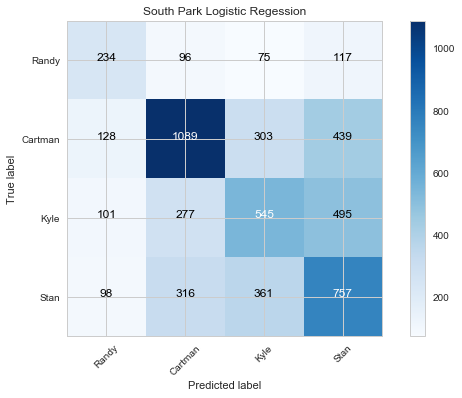

In [19]:
# Собственно, ненормализованная матрица:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['Randy', 'Cartman', 'Kyle', 'Stan'],
                      title='South Park Logistic Regession')

Normalized confusion matrix
[[ 0.44827586  0.18390805  0.14367816  0.22413793]
 [ 0.06533946  0.55589587  0.15467075  0.22409393]
 [ 0.07122708  0.19534556  0.38434415  0.34908322]
 [ 0.06396867  0.20626632  0.23563969  0.49412533]]


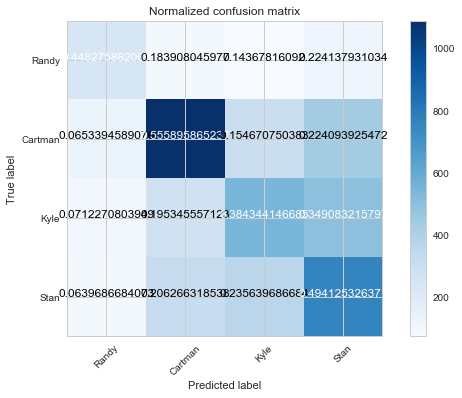

In [20]:
# и нормализованная:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Randy', 'Cartman', 'Kyle', 'Stan'], normalize=True,
                      title='Normalized confusion matrix')

In [21]:
print(log2.classes_)
print(log2.coef_)
print(log2.intercept_)
#есть массивы с признаками, каждый массив соответствует одному из классов (имена персонажей). Каждый признак выражен
#коэффициентом, который показывает принадлежность признака к какому-то из персонажей.
#то есть если признак положительный, то он повышает вероятность принадлежности фразы к персонажу
#отрицательный признак наоборот говорит о том, что реплика персонажу не принадлежит.
#чем больше число по модулю, тем сильнее вероятность (в ту или иную сторону)

['Butters' 'Cartman' 'Kyle' 'Stan']
[[ -1.96355544e-02  -3.81550364e-01  -9.08979456e-01 ...,  -1.81585005e-02
   -1.20103663e-04  -5.89355316e-05]
 [  3.31240735e-01  -5.73449206e-02   5.55312084e-01 ...,   2.08027390e-01
   -1.11169470e-01   3.82094825e-01]
 [ -5.11987656e-02   1.40772389e-01   2.68054789e-02 ...,  -1.46494821e-01
   -1.40529673e-02  -8.39204995e-02]
 [ -5.23946890e-01   1.15401225e-01  -3.21407959e-01 ...,  -7.64909798e-02
    2.67144384e-02  -2.09081949e-01]]
[-1.39173306 -1.52979981 -0.79204229 -0.5592067 ]


In [22]:
#Tf-Idf Vectorizer вместо CountVectorizer
tf = TfidfVectorizer(tokenizer=word_tokenize , stop_words="english")
tr_tf = tf.fit_transform(X_train)
tst_tf = tf.transform(X_test)
Log3 = LogisticRegression(class_weight = 'balanced')
Log3.fit(tr_tf, y_train)
pred = Log3.predict(tst_tf)
print(classification_report(y_test, pred)) 
#хуже угадывает Баттерса, но в целом то же самое (но чуть хуже)

             precision    recall  f1-score   support

    Butters       0.41      0.48      0.44       522
    Cartman       0.57      0.62      0.60      1959
       Kyle       0.43      0.35      0.38      1418
       Stan       0.43      0.43      0.43      1532

avg / total       0.48      0.48      0.48      5431



Axes(0.125,0.125;0.775x0.755)


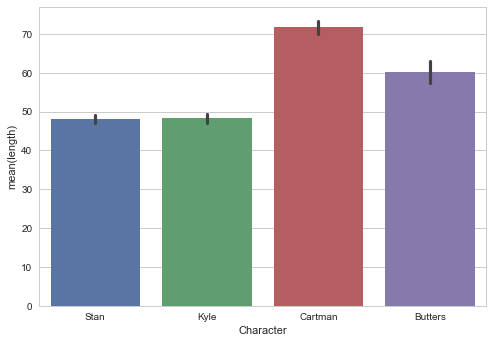

In [23]:
#Некоторые герои говорят более длинными фразами. Того же Кайла не раз упрекали в его "двигании речей".
#Проверим по этой фиче

characters['length'] = characters['Line'].map(lambda text: len(text)) 

print(sns.barplot(x="Character", y="length",  data=characters))
#хм...в итоге оказалось, что Кайл и Стэн как раз говорят короткими фразами (относительно Картмана, у которого длина фразы 72 и Баттерса с 60)

In [24]:
#попробуем предугадать персонажей с учетом длины слов
characters['length'].fillna((characters['length'].mean()), inplace=True)

In [25]:
X, y  = characters['length'], characters['Character']
X = X[:, None]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [26]:
pred = rf.predict(X_test)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

    Butters       0.07      0.00      0.00       518
    Cartman       0.40      0.68      0.50      1954
       Kyle       0.32      0.15      0.20      1430
       Stan       0.32      0.29      0.30      1529

avg / total       0.32      0.37      0.32      5431



In [27]:
#Байес
b = MultinomialNB()
b.fit(X_train, y_train)

pred = b.predict(X_test)
print(classification_report(y_test, pred)) 

             precision    recall  f1-score   support

    Butters       0.00      0.00      0.00       518
    Cartman       0.36      1.00      0.53      1954
       Kyle       0.00      0.00      0.00      1430
       Stan       0.00      0.00      0.00      1529

avg / total       0.13      0.36      0.19      5431



D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
#Регрессия
log3 = LogisticRegression(class_weight = 'balanced')
log3.fit(X_train, y_train) 

pred = log3.predict(X_test)
print(classification_report(y_test, pred)) 


             precision    recall  f1-score   support

    Butters       0.00      0.00      0.00       518
    Cartman       0.43      0.54      0.48      1954
       Kyle       0.00      0.00      0.00      1430
       Stan       0.31      0.61      0.41      1529

avg / total       0.24      0.37      0.29      5431



D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#Получилось не очень: Кайл и Стэн предугадываются очень плохо/никак не предугадываются, и из-за этого страдает эффективность в целом.
#Таким образом получается, что лучше не изобретать что-то новое, а использовать LogisticRegression с данными, векторизированными
#через CountVectorizer